In [1]:
from quri_vm import VM
from quri_parts.backend.devices import clifford_t_device
from quri_parts.backend.units import TimeUnit, TimeValue

def get_vm(qubit_count: int=8, code_distance: int=7, qec_cycle_us: float=1.0, delta_sk: float=1.0e-4, physical_error_rate: float=1.0e-4, mode_block: str = "compact") -> VM:
    return VM.from_device_prop(clifford_t_device.generate_device_property(
        qubit_count=qubit_count,
        code_distance=code_distance,
        qec_cycle=TimeValue(qec_cycle_us, TimeUnit.MICROSECOND),
        delta_sk=delta_sk,
        physical_error_rate=physical_error_rate,
        mode_block=mode_block
    ))


In [2]:
from functools import cache

from quri_algo.circuit.time_evolution.trotter_time_evo import TrotterTimeEvolutionCircuitFactory
from quri_algo.problem import QubitHamiltonianInput
from quri_parts.circuit import NonParametricQuantumCircuit
from quri_parts.core.operator import Operator, pauli_label

def get_operator(qubit_count: int) -> Operator:
    op = Operator()
    for q in range(qubit_count):
        for p in ['X', 'Y', 'Z']:
            op.add_term(pauli_label(p + str(q) + ' ' + p + str((q+1)%qubit_count)), 1.0)
    
    return op

class HeisenbergTimeEvolutionCircuitFactory:
    """Time-evolution circuit factory
    
    This class wraps TrotterTimeEvolutionCircuitFactory and allows creating circuits specifically for the Heisenberg model by calling it with the qubit count and evolution time"""
    # Return a time-evolution circuit factory and cache it
    @cache
    def get_circuit_factory(self, qubit_count:int, n_trotter: int) -> TrotterTimeEvolutionCircuitFactory:
        operator = get_operator(qubit_count)
        hamiltonian_input = QubitHamiltonianInput(qubit_count, operator)

        return TrotterTimeEvolutionCircuitFactory(hamiltonian_input, n_trotter)

    def __call__(
        self, evolution_time: float, qubit_count: int, n_trotter: int
    ) -> NonParametricQuantumCircuit:
        circuit_factory = self.get_circuit_factory(qubit_count, n_trotter)
        return circuit_factory(evolution_time=evolution_time)

## Rules of the surface code

Generally the surface code allows different implementations in terms of the ways that error corrected logical qubit patches can interact. However, whichever strategy is chosen the overall steps are

- Clifford gates are implemented using lattice surgery where possible and transversally otherwise
- T-gates are implemented by consuming magic states through a gate-teleportation protocol
- Magic state factories must continuously create magic states for consumption by data blocks which perform operation on several qubits at once

In this section we will discuss the different choices in data-blocks and experiment with three different layouts - Compact, intermediate and fast. To read more about them we refer to Litinski's [A Game of Surface Codes](https://quantum-journal.org/papers/q-2019-03-05-128/).



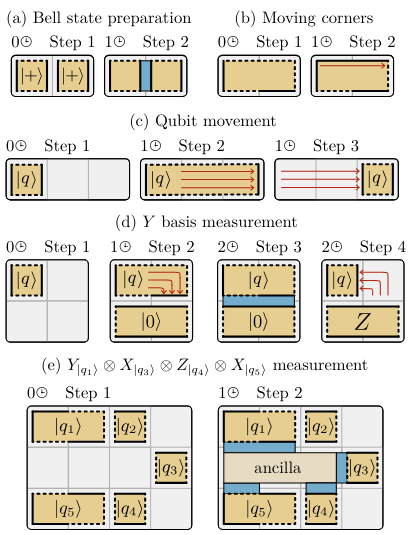

### Types of operations implemented on patches

The following operations can be done directly through manipulations of the surface code qubits while quantum error correction is performed concurrently.

1. Qubit initialization - either as single qubit patches or two-qubit patches, but only in specific states unless some finite error is tolerated.
2. Qubit measurement - This can be done as single-patch, two-pach or multi-patch measurements, each with some differences in how they are carried out. Multi-patch measurements typically involve creating an ancilla-patch to carry out the measurements, where the ancilla determines the basis.
3. Edges and corner of a patch can be moved to change its size and to reshape its boundary - before performing multi-qubit measurement, this is often required.

The figure above summarizes these operations briefly. Importantly, they can be performed in a constant number of time-steps, where each time-step is $O(d)$ quantum error correction cycles. The required foot-print depends on the type of data-block chosen and the number of qubits. Using the multi-patch measurement, gate teleportation can be implemented and by doing so arbitrary quantum computation can be carried out through the Clifford+T decomposition with by using magic states for the measurements.

The required number of tiles $s$ and the code distance $d$ determines the physical footprint required as $sd^2$, while the time cost is $td$, i.e. the number of time-steps times the code distance. The product of the physical footprint and time-cost yields the space-time cost, $std^3$ - as a rule of thumb the space-time resources required therefore scales as $d^3$.

Thus for arbitrary quantum computation to be achieved it is important to have data processing blocks available which perform the above mentioned operations while being fed a steady supply of magic states. Optimizing for the lowest execution time has been shown to be NP-hard, so rather than finding optimal layouts for the logical patches and magic state distillation units, a heuristic is used where different data-blocks are considered based on their trade-offs between execution time and physical footprint. We do not go into detail here on magic state distillation - it is assumed that magic state distillation is available through a dedicated magic state distillation unit.

## Data blocks

We will here discuss the three different data-blocks simulated by QURI VM. In the following we use figures from the aforementioned [A Game of Surface Codes](https://quantum-journal.org/papers/q-2019-03-05-128/), and we also describe the time required for each step using their convention, i.e. one time-step for a code distance $d$ patch requires $d$ error correction cycles (in addition to some constant term, which will be ignored).

### Compact

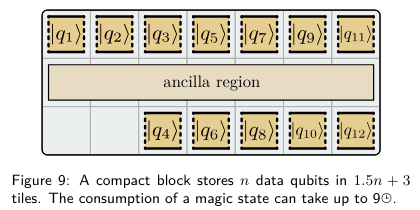

The compact block performs logical operations on $n$ qubits, but its footprint is $1.5n + 3$ tiles. Because the patches here only take up one tile, they may only expose one edge to the ancilla region, and because of this, by default only $Z$ measurements can be performed. In order to do $X$ meausrements the qubits must be rotated, which takes up to 3 error correction cycles. In order to perform $Y$ measurements, the measurement has to be decomposed as a series of single-qubit rotations and $X$ or $Z$ measurements.

### Intermediate


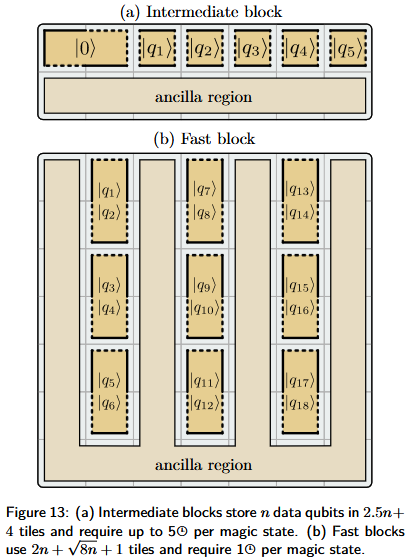

The intermediate block requires $2.5n + 4$ tiles and requires at most 5 time-steps to execute an instruction. It is expected to be faster on average compared to the compact block because data-patches can be rotated in parallel and the rotations themselves only take 2 time-steps.

### Fast

Fast blocks are laid out in such a way that both the $Z$ and $X$ boundaries of each data-patch is exposed at any time. This means that rotations are not required when multi-patch measurements are taken. Each patch is a two-qubit patch with edges arranged so that one qubit is accessible from the left boundary and another one is accessible from the right one. The fast block has the lowest space-time cost of the three designs mentioned, so whenever feasible it is preferrable over other schemes.

In [ ]:
mode_blocks = ["compact", "intermediate", "fast"]
QUBIT_COUNT = 8

for block in mode_blocks:
    vm = get_vm(qubit_count=QUBIT_COUNT, mode_block=block)
